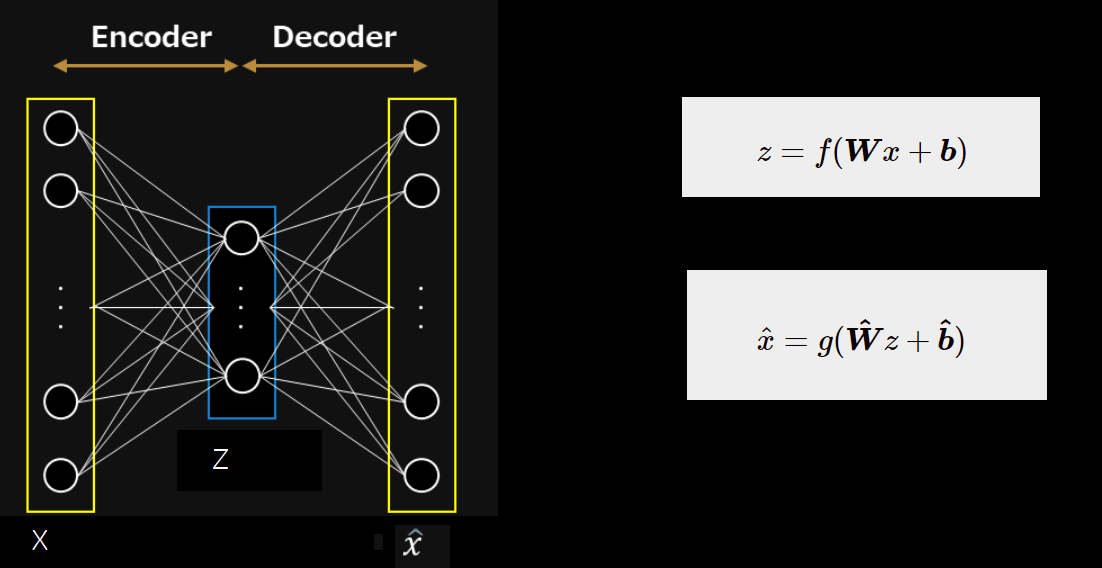

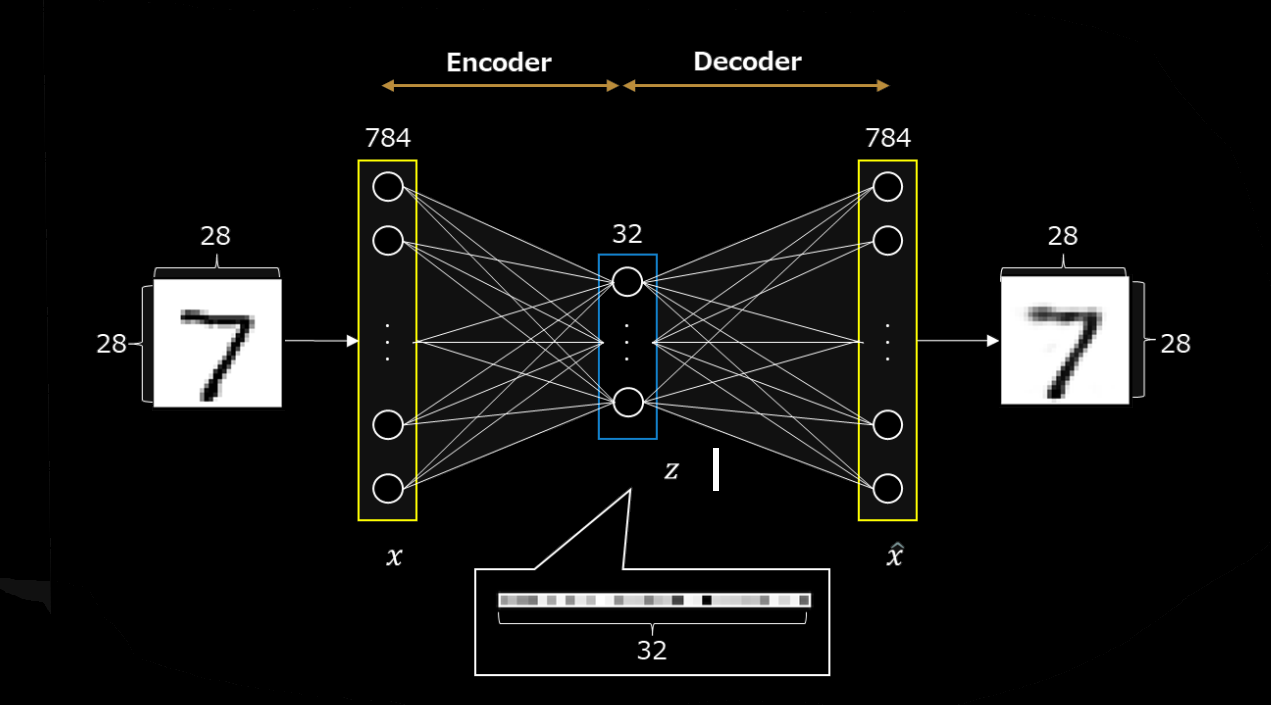

### Q1)  MNIST의 숫자 데이터를 재구성하는 자동 인코더를 구현해보자. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
import copy
from IPython import display

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

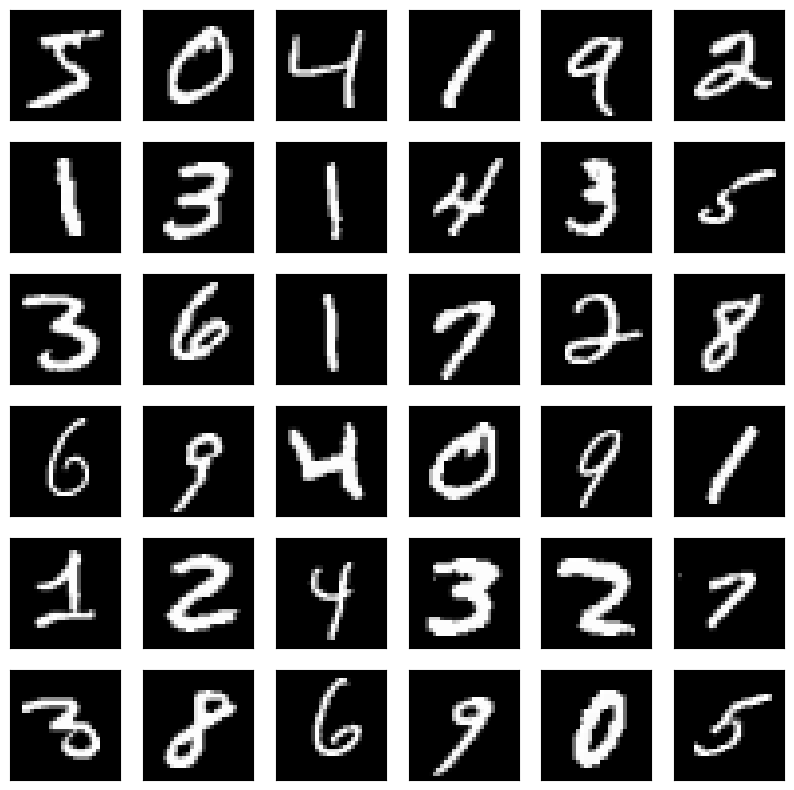

In [3]:
def plot_imgs(imgs,shuffle=False):
    plt.figure(figsize=(10,10))
    plot_imgs = copy.deepcopy(imgs)
    if shuffle:
        np.random.shuffle(plot_imgs)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(imgs[i]), cmap="gray", vmin=0, vmax=1)
    plt.show()
plot_imgs(x_train)

In [4]:
#인코더  28*28 데이터를 잠재적 공간의 고정된 차원을 32차원으로 지정 
inputs = layers.Input(shape=(28, 28, 1)) 

# 3*3필터를 16개 사용  ,  padding='same'로 입출력 크기를 동일 ,strides=2 이미지크기   
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(inputs)

# 3*3필터를 8개 사용
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(x)

# 2D-> 1D로 변환 
x = tf.keras.layers.Flatten()(x)

encoded = layers.Dense(32)(x)  # 잠재영역 Z   -> 잠재 공간의 차원은 인코더가 생성하는 모든 입력 이미지에 대한 내부 표현 크기
encoder = tf.keras.Model(inputs, encoded)  #모델 생성  

In [5]:
#32차원 데이터에서 28×28 데이터로 디코더 생성 

#1D  -> 2D 
x = layers.Dense(7*7)(encoded)  # 잠재영역 Z 공간  정의한 것  . 7*7 = 49 크기 벡터 변환 ( 이미지 복원전 초기 값 지정 )
x = layers.Reshape((7,7,1))(x)  #   7*7 ,  1   2D 형태 재구성  

# 역 합성곱  => 이미지 차원 확장할 때 사용된다. 
x = layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(x)  # 14*14 
x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(x) # 28*28 

# 재구성된 x값을 생성, sigmoid픽셀값을  0 ~ 1로 제한 
decoded = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
decoder = tf.keras.Model(encoded, decoded)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 32)                12576     
                                                                 
 dense_1 (Dense)             (None, 49)                1617      
                                                                 
 reshape (Reshape)           (None, 7, 7, 1)           0  

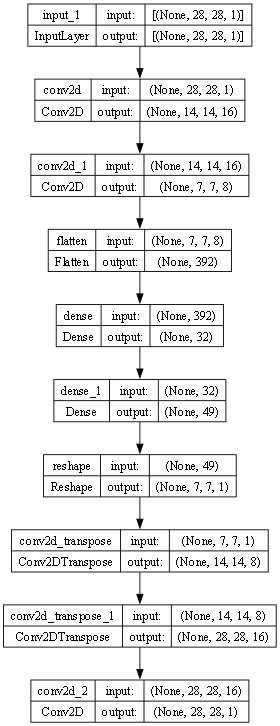

In [6]:
#inputs 와 인코더와  출력인 decoded 를 연결해 (encoder, decoder 를 연결해) 오토 인코더를 생성
autoencoder = tf.keras.Model(inputs, decoded)  # 모델로 결합  
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=64)

In [7]:
n = 10
input_num = 100
def plot_rec(input_images):
    plt.figure(figsize=(20, 4))
    decoded_imgs = autoencoder(input_images[:input_num], training=True)
    plt_index = np.random.randint(0,input_num,size=n)
    decoded_imgs = tf.squeeze(decoded_imgs)
    input_images = np.squeeze(input_images)

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        idx = plt_index[i]
        plt.imshow(input_images[idx], cmap="gray", vmin=0, vmax=1)
        plt.title("input")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[idx], cmap="gray", vmin=0, vmax=1)
        plt.title("output")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

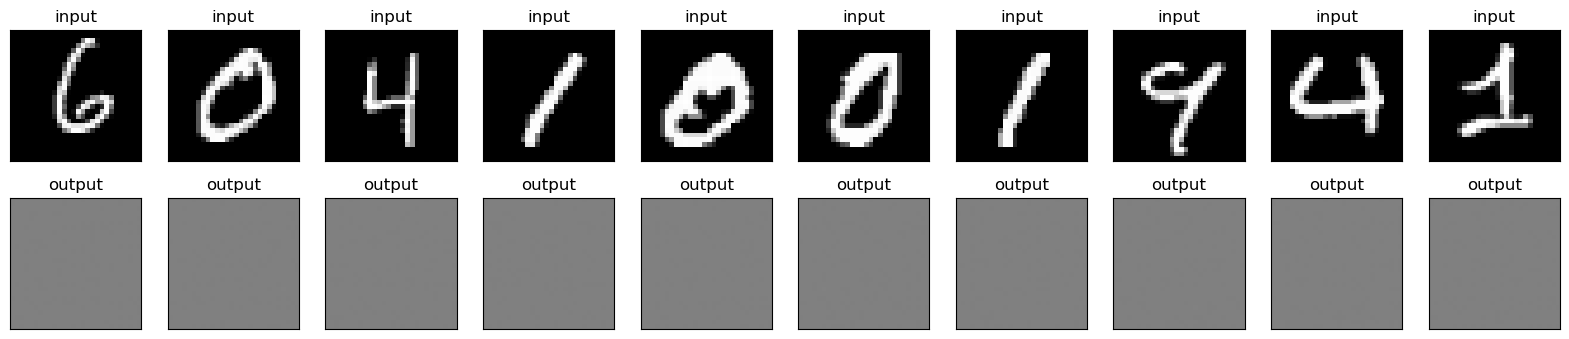

In [8]:
plot_rec(x_train)

In [9]:
autoencoder.fit(x_train,x_train,epochs=100, batch_size=120, shuffle=True, validation_data=(x_test,x_test))

Epoch 1/100

500/500 [==============================] - 12s 19ms/step - loss: 0.2379 - val_loss: 0.1276
Epoch 2/100
500/500 [==============================] - 7s 15ms/step - loss: 0.1181 - val_loss: 0.1106
Epoch 3/100
500/500 [==============================] - 6s 12ms/step - loss: 0.1083 - val_loss: 0.1045
Epoch 4/100
500/500 [==============================] - 6s 13ms/step - loss: 0.1040 - val_loss: 0.1014
Epoch 5/100
500/500 [==============================] - 6s 13ms/step - loss: 0.1018 - val_loss: 0.0999
Epoch 6/100
500/500 [==============================] - 6s 13ms/step - loss: 0.1005 - val_loss: 0.0990
Epoch 7/100
500/500 [==============================] - 6s 13ms/step - loss: 0.0996 - val_loss: 0.0982
Epoch 8/100
500/500 [==============================] - 8s 17ms/step - loss: 0.0990 - val_loss: 0.0976
Epoch 9/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0985 - val_loss: 0.0973
Epoch 10/100
500/500 [==============================] - 10s 20ms/step - loss: 0.

500/500 [==============================] - 8s 17ms/step - loss: 0.0935 - val_loss: 0.0925
Epoch 79/100
500/500 [==============================] - 7s 15ms/step - loss: 0.0935 - val_loss: 0.0926
Epoch 80/100
500/500 [==============================] - 12s 23ms/step - loss: 0.0935 - val_loss: 0.0925
Epoch 81/100
500/500 [==============================] - 7s 15ms/step - loss: 0.0935 - val_loss: 0.0925
Epoch 82/100
500/500 [==============================] - 7s 14ms/step - loss: 0.0935 - val_loss: 0.0925
Epoch 83/100
500/500 [==============================] - 11s 22ms/step - loss: 0.0934 - val_loss: 0.0925
Epoch 84/100
500/500 [==============================] - 9s 18ms/step - loss: 0.0934 - val_loss: 0.0925
Epoch 85/100
500/500 [==============================] - 11s 22ms/step - loss: 0.0934 - val_loss: 0.0926
Epoch 86/100
500/500 [==============================] - 13s 26ms/step - loss: 0.0934 - val_loss: 0.0925
Epoch 87/100
500/500 [==============================] - 11s 22ms/step - loss: 0.09

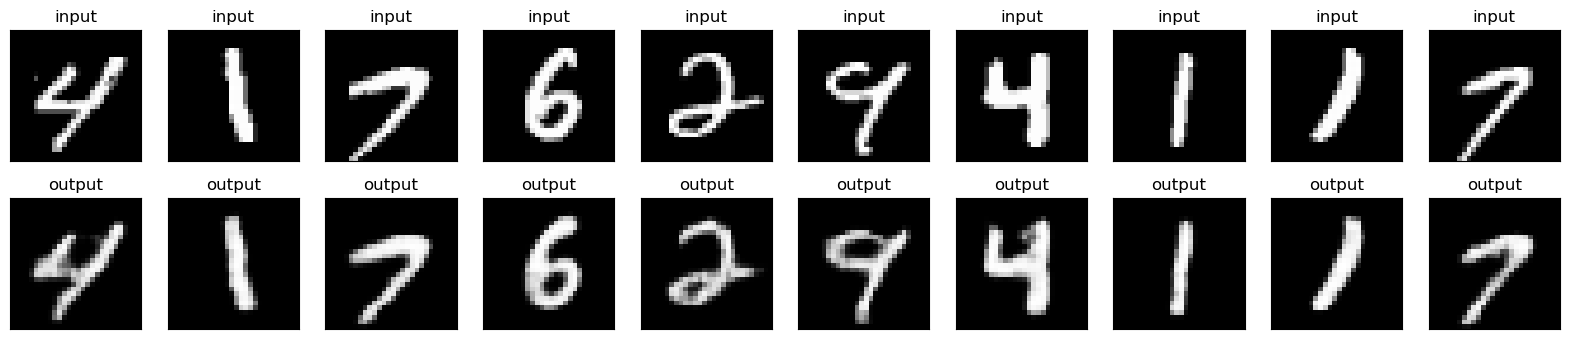

In [10]:
plot_rec(x_train)

### Variational Auto Encoder（VAE）

- VAE에서는 Encoder를 사용하여 평균 벡터 μ 및 분산 벡터 σ를 사용한다. 

- 평균 벡터, 분산 벡터를 바탕으로, 다변량 가우스 분포로부터 잠재 변수 z , 샘플링 VAE에서 Encoder를 사용하여 평균 벡터 μ
   및 분산 벡터 σ를 사용한다
   
-  입력 데이터 → Encoder → [확률 분포 (평균 μ, 분산 σ의 가우스 분포) → z (잠재 변수)] → Decoder → 출력 데이터

- AE -> 인코더 부분 과 손실함수 부분이 변경된다.  

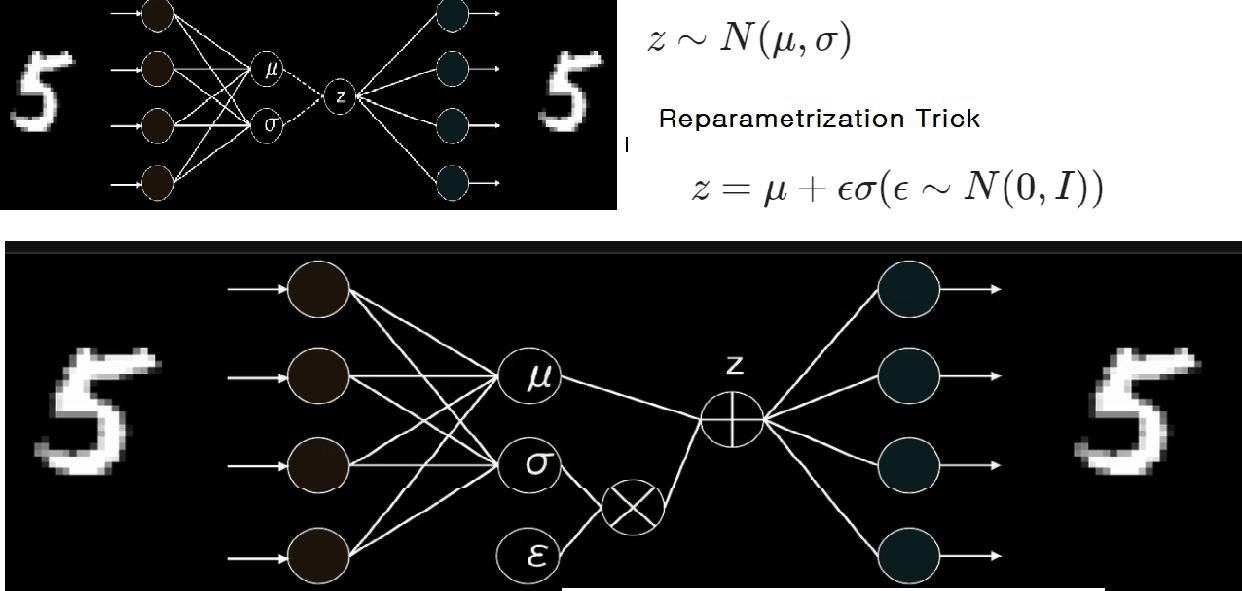

mnist_train (70000, 28, 28, 1)
x_train (60000, 28, 28)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 14, 14, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 3136)                 0         ['conv2d_4[0][0]']            
                                     

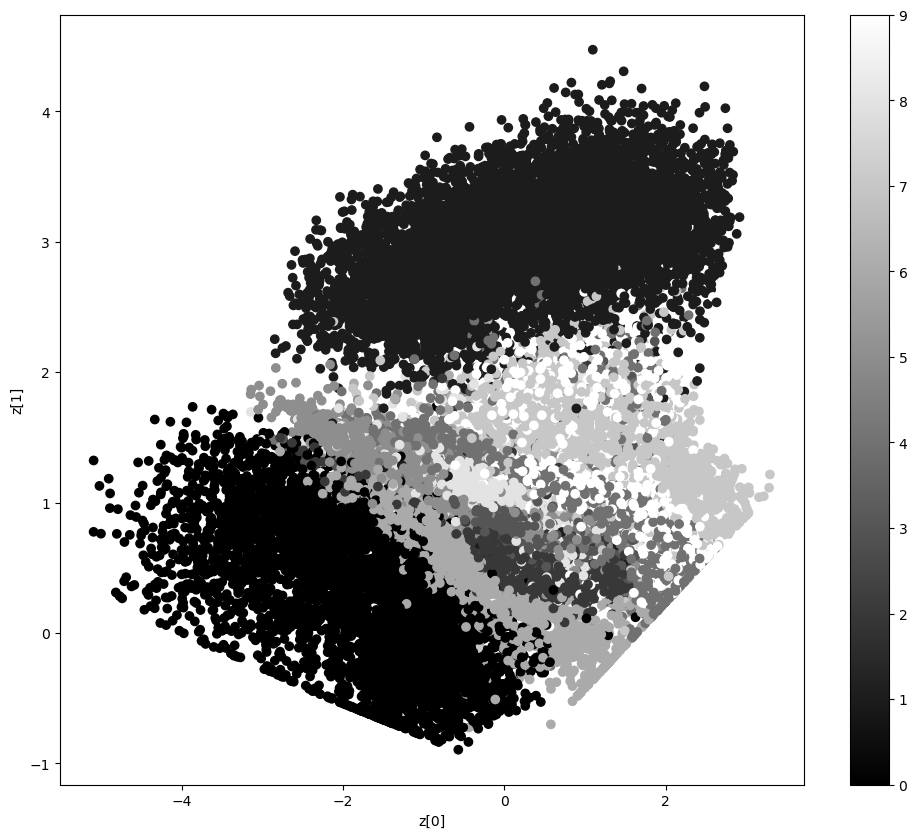

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

#2-1. Datasets 로드 
(x_train, _), (x_test, _) = mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
print('mnist_train',mnist_digits.shape)
print('x_train',x_train.shape)


#2-2 정규화
x_train = x_train / 255.0
x_test = x_test / 255.0


#3-1  Autoencoder 변수사용 
epochs = 20
batch_size = 256
n_z = 2  

#3-2 히든변수 Z를 샘플링하기 위한 함수
# args = [z_mean, z_log_var]
def func_z_sample(args):  # 미분이 불가능하기 때문에  가능하도록 사용자 함수 적용 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_log_var), mean=0, stddev=1)  # 표준 정규분포에  샘플링된 노이즈  
    return z_mean + epsilon * K.exp(z_log_var/2)#z_log_var의 절반에 해당하는 표준편차에 곱한다음 z_mean 합해서 리턴

#3-3# VAE Network
#Enocoder 
encoder_inputs = Input(shape=(28,28,1))
x = Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
x = Conv2D(64,3,activation='relu',strides=2, padding='same')(x)
x = Flatten()(x)  # 1D 변환  
x = Dense(16, activation='relu')(x)

#######  추가되는 부분  : 잠재 변수 매개변수 생성  
#n_z = 2  : 잠재 공간의 차원수  
z_mean = Dense(n_z, name='z_mean')(x)  #평균
z_log_var = Dense(n_z, name='z_log_var')(x) #로그 분산  

##### 
z = Lambda(func_z_sample, output_shape=(n_z))([z_mean, z_log_var])
#######################################
encoder = Model(encoder_inputs, [z_mean, z_log_var,z], name='encoder')
encoder.summary()

#3-5 Decoder
latent_inputs = Input(shape=(n_z,))
x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64,3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32,3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = Conv2DTranspose(1,3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

################### 사용자 모델 구축  [ 인코더, 디코더 ] -> 재구성  -> 재구성손실, KL발산  

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self,data): # 모델의 훈련 과정 정의 (재구성손실 + KL 손실계산  =  최종손실 )
       
        if isinstance(data, tuple):  # (입력데이터,레이블)   VAE 는 레이블이 필요없음  
            data = data[0]
        
        
        with tf.GradientTape() as tape: # 자동 미분을 위한 컨텍스트 
            z_mean, z_log_var, z = encoder(data)# 입력데이터를 받아서 잠재변수평균, 로그분산, 샘플링 잠재변수z 
            
            reconstruction = decoder(z) # 데이터 재구성  
            
            reconstruction_loss = tf.reduce_mean(
                losses.binary_crossentropy(data,reconstruction)
            )# 재구성된  데이터와 원본 데이터 사이의 이진 크로스엔트로피 손실을 계산  
            
            reconstruction_loss *= 28 * 28  # 손실값을 이미지의 픽셀수로 조정  
            
            #KL 손실계산  -> 잠재 변수의 분포가 사전분포(표준 정규분포)에서 얼마나 벗어나는지 측정 
            kl_loss = 1 + z_log_var -tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss) # kl 손실의 평균 
            kl_loss *= -0.5 # 손실을 음수로 만들어 최적화 과정에서 최소화 시키는 목적 
            total_loss = reconstruction_loss + kl_loss  # 재구성손실 + KL 손실  

        # 총손실에 대한 모델 훈련가능한 가중치들의 그래디언트 계산
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        #계산된 그라디언트를 사용하여 옵티마이저를 통해 모델의 가중치를 업데이트 한다. 
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return{
            "loss": total_loss,
            "reconstruction loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }# 각 훈련시 에폭한 후에 모니터링할 수 있다.  

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())
vae.fit(mnist_digits, epochs=epochs, batch_size=batch_size)


#잠재공간 시각화  
def plot_label_clusters(encoder, decoder, data, labels):   
    z_mean, _, _ = encoder.predict(data) # 잠재 공간의 평균값 
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)

### Q3) 간단한 AE 모델을 만들자. 

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.layers import *
input_img  = Input(shape =(28,28,1))

#3-1 encoded  
x = Conv2D(16,(3,3) ,activation='relu',padding='same')(input_img)
x = MaxPooling2D((2,2) ,padding='same')(x)

x = Conv2D(8,(3,3) ,activation='relu',padding='same')(x)
x = MaxPooling2D((2,2) ,padding='same')(x)

x = Conv2D(8,(3,3) ,activation='relu',padding='same')(x)
encoded = MaxPooling2D((2,2) ,padding='same')(x)

#3-2 decoded  
x = Conv2D(8,(3,3) ,activation='relu',padding='same')(encoded)
x= UpSampling2D((2,2))(x)

x = Conv2D(8,(3,3) ,activation='relu',padding='same')(x)
x= UpSampling2D((2,2))(x)

x = Conv2D(16,(3,3) ,activation='relu',padding='same')(x)
x= UpSampling2D((2,2))(x)

decoded = Conv2D(1,(3,3)  ,activation='sigmoid',padding='same')(x) 

#3-3  AE   생성 
autoencoder  = Model(input_img , decoded  )

#3 -4  컴파일   o=adadelta  loss = b_c 
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#autoencoder.summary()

### Q4) Q3을 간단한 VAE 모델로 변경해 보자. 

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras import backend as k
from tensorflow.keras import losses
from tensorflow.keras.layers import *
from keras.models import Model

#4-1 Z 영역 정규 분포 구현 샘플링   -> 정규 분포영역에서 포인트 샘플링 Z를 샘플링한다.
def sampling(args):
    z_mean, z_log_var = args 
    latent_dim = 32
    epsilon_std =1.0 
    
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.shape(z_mean)[1],K.shape(z_mean)[2], latent_dim)
                              , mean=0, stddev=epsilon_std)
    return z_mean + epsilon * K.exp(z_log_var/2)
    

#4-2 encoder 
input_img = Input(shape=(32, 32, 1))

latent_dim = 32

x = Conv2D(32,(3,3) ,activation='relu',padding='same')(input_img)
x = MaxPooling2D((2,2) ,padding='same')(x)

x = Conv2D(64,(3,3) ,activation='relu',padding='same')(x)
x = MaxPooling2D((2,2) ,padding='same')(x)

x = Conv2D(32,(3,3) ,activation='relu',padding='same')(x)
x = MaxPooling2D((2,2) ,padding='same')(x)

x = Conv2D(16,(3,3) ,activation='relu',padding='same')(x)
encoded = MaxPooling2D((2,2) ,padding='same')(x)




# 4-3 잠재 변수 영역  
z_mean  = Dense (latent_dim , name ='z_mean')(encoded)
z_log_var= Dense(latent_dim , name ='z_log_var')(encoded)

z = Lambda(sampling)([z_mean ,z_log_var ])

#4-4 decoder 

x = Conv2D(16,(3,3) ,activation='relu',padding='same')(z)
x= UpSampling2D((2,2))(x)

x = Conv2D(32,(3,3) ,activation='relu',padding='same')(x)
x= UpSampling2D((2,2))(x)

x = Conv2D(64,(3,3) ,activation='relu',padding='same')(x)
x= UpSampling2D((2,2))(x)

x = Conv2D(32,(3,3) ,activation='relu',padding='same')(x)
x= UpSampling2D((2,2))(x)

decoded = Conv2D(1,(3,3)  ,activation='sigmoid',padding='same')(x) 

#4-5 
autoencoder=Model (input_img, decoded )

#4-6  loss함수 변경  
#computer VAE loss 
xent_loss = K.mean(tf.keras.metrics.binary_crossentropy (input_img, decoded), axis=-1)
kl_loss = -0.5 * k.mean(K.sum(1 + K.log(K.square(z_log_var)) - K.square(z_mean) - K.square(z_log_var), axis=-1))
vae_loss  = k.mean(xent_loss +  kl_loss  )

autoencoder.add_loss(vae_loss)
autoencoder.compile(optimizer='adam') 

In [14]:
autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 32, 32, 32)           320       ['input_6[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_12[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 16, 16, 64)           18496     ['max_pooling2d_3[0][0]'

 mbda)                                                                                            
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 32, 32)               0         ['tf.keras.backend.binary_cros
 ambda)                                                             sentropy[0][0]']              
                                                                                                  
 tf.math.reduce_mean_2 (TFO  ()                           0         ['tf.math.reduce_sum[0][0]']  
 pLambda)                                                                                         
                                                                                                  
 tf.math.reduce_mean_1 (TFO  (None, 32)                   0         ['tf.math.reduce_mean[0][0]'] 
 pLambda)                                                                                         
          

###  Q5)  이미지를 생성해 보자. 

In [15]:
(x_train, _), (x_test, _) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE 모델 구축
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 잠재 공간 샘플링 함수
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# 디코더 모델
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE 모델
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# VAE 손실 함수
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

# 잠재 공간에서 숫자 이미지 생성
def generate_digit_image(latent_space_vector):
    generated_image = decoder.predict(np.array([latent_space_vector]))
    generated_image = generated_image.reshape(image_size, image_size)
    return generated_image

# 잠재 공간 벡터 예제: 이 값을 변경하여 다른 숫자를 생성할 수 있음
latent_space_vector = [1, 2]
generated_image = generate_digit_image(latent_space_vector)

# 생성된 이미지 시각화
plt.imshow(generated_image, cmap='gray')
plt.show()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense_4[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense_4[0][0]']             
                                                                                            

NameError: name 'binary_crossentropy' is not defined